# Calibrate solar and volcanic


We have to use HadGEM3-GC31-LL RFMIP experiments, as UKESM didn't do them. But since the radiation code is the same, and I don't think the chemistry changes in UKESM1 is going to affect anything, I think this is OK.

Equations to use:
- volcanic = -19.742 AOD + 0.31227
- solar = 0.168197 TSI - 228.097

In [1]:
import pooch
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from scipy.stats import linregress

In [2]:
solar_forcing_file = pooch.retrieve(
    url="https://cloud.iaa.es/index.php/s/5qHwdy72pSjbWzs/download/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_18500101-22991231.nc.gz",
    known_hash="2afd5ed359d4c2d5416c60e37982d7d27db6ada05402b5a93158fb8a8533f05d",
    processor=pooch.Decompress()
)

In [3]:
nc = Dataset(solar_forcing_file)
tsi_monthly = nc.variables['tsi'][:]
nc.close()

In [4]:
years = np.arange(1850, 2300, dtype=int)
isleap = np.zeros(450)
isleap[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 1

In [5]:
tsi = np.zeros(450)
for i, year in enumerate(years):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[i] = np.average(tsi_monthly[(i)*12:(1+i)*12], weights=weights)

In [6]:
tsi_baseline = np.mean(tsi[:24])
tsi_baseline

np.float64(1360.7481368624874)

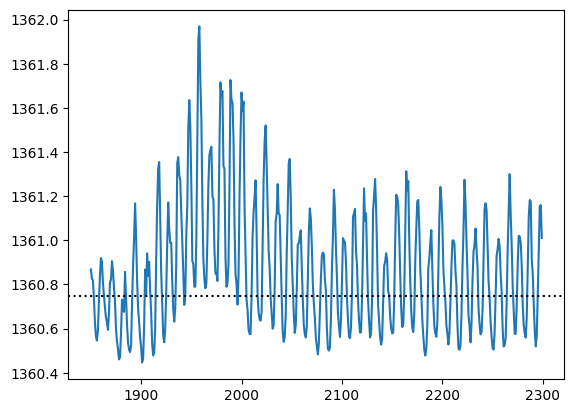

In [7]:
pl.plot(np.arange(1850, 2300), tsi)
pl.axhline(tsi_baseline, ls=':', color='k')

In [8]:
rfmip_tier2 = pd.read_csv('../data/smith2021/RFMIP-ERF-tier2.csv', index_col=0)
natural = rfmip_tier2[['HadGEM3-GC31-LL NAT']]
natural

,HadGEM3-GC31-LL NAT
year,
1850,0.217894
1851,0.280323
1852,0.137737
1853,0.189263
1854,0.158687
...,...
2096,0.103691
2097,0.154095
2098,0.031064


In [9]:
# the original CMIP6 link does not seem to exist any more, grab from USask
volcanic_saod = pooch.retrieve(
    'https://arggit.usask.ca/cj/eva-data-hub/-/raw/main/data/CMIP_1850_2014_extinction_550nm_strat_only_v3.nc',
    known_hash = 'md5:ab97e78faf5fdccdf67cfd7ced68b20e'
)

In [10]:
nc = Dataset(volcanic_saod)
ext = nc.variables['ext550'][:].transpose((2,1,0))  # time, height, lat
lev = nc.variables['altitude'][:]
lat = nc.variables['latitude'][:]
time = nc.variables['month'][:]
print(nc.variables['month'])
nc.close()

<class 'netCDF4.Variable'>
float32 month(month)
    units: month_from_jan_1960
unlimited dimensions: 
current shape = (1980,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [11]:
lat_bnds = np.concatenate(([-90], 0.5*(lat[1:]+lat[:-1]), [90]))
weights = np.diff(np.sin(np.radians(lat_bnds)))
tax = np.zeros(165*12)
aod_cmip6 = np.zeros(165*12)
for i in range(0,1970,12):
    gl_mn_OD = np.average(np.sum(np.mean(ext[i:i+12,...],axis=0) * 0.5 ,axis=0),weights=weights) # 0.5 is thickness in km

for i in range(1980):
    aod_cmip6[i] = np.average(np.sum(ext[i,...] * 0.5,axis=0),weights=weights)

In [12]:
aod_cmip6

array([0.00276368, 0.0027699 , 0.00274665, ..., 0.00711638, 0.00677946,
       0.00679216], shape=(1980,))

In [13]:
gl_mn_OD

np.float64(0.006595506929429253)

In [14]:
years = np.arange(1850, 2015, dtype=int)
aod = np.zeros(165)
for i, year in enumerate(years):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    aod[i] = np.average(aod_cmip6[(i)*12:(1+i)*12], weights=weights)

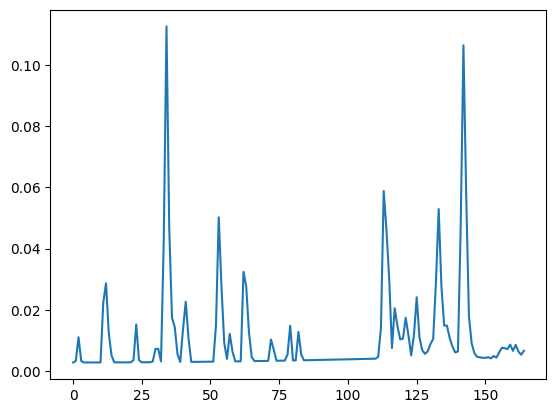

In [15]:
pl.plot(aod)

(np.float64(-19.74200064323273), np.float64(0.3122707285966036))

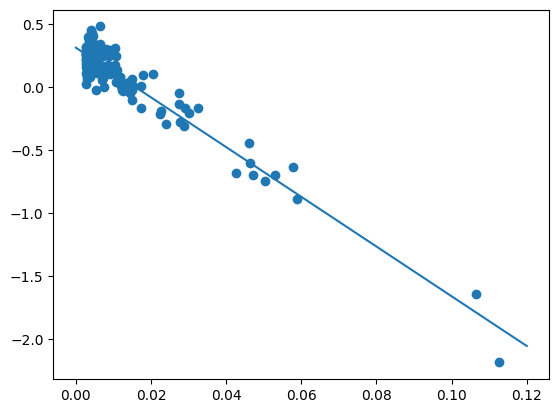

In [16]:
pl.scatter(aod, natural.values[:165])
sl, ic, _,_,_ = linregress(aod, natural.values[:165].squeeze())
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl, ic

In [17]:
volcanic_1850_2300 = np.zeros((451))
volcanic_1850_2300[1:166] = sl * aod + ic
volcanic_1850_2300[165:175] = np.linspace(volcanic_1850_2300[165], 0, 10)

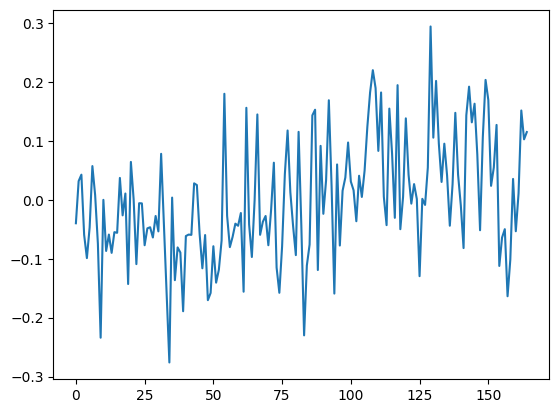

In [18]:
resid = natural.values[:165].squeeze() - (sl * aod + ic)
pl.plot(resid)

(np.float64(0.1681973859425892), np.float64(-228.90726123023111))

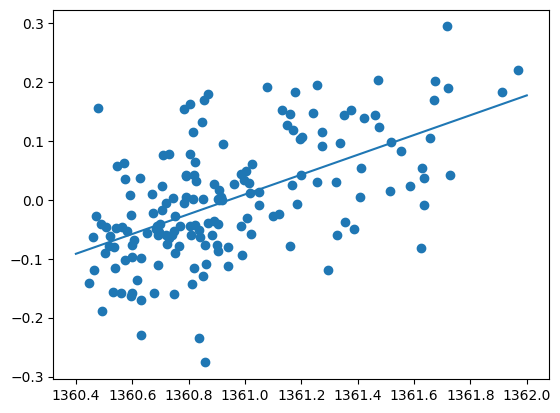

In [19]:
pl.scatter(tsi[:165], resid)
sl, ic, _,_,_ = linregress(tsi[:165], resid)
pl.plot(np.linspace(1360.4,1362,100), sl*np.linspace(1360.4,1362,100)+ic)
sl, ic

In [20]:
tsi.shape

(450,)

In [21]:
solar_1850_2300 = np.zeros(451)
solar_1850_2300[1:] = sl * tsi + ic

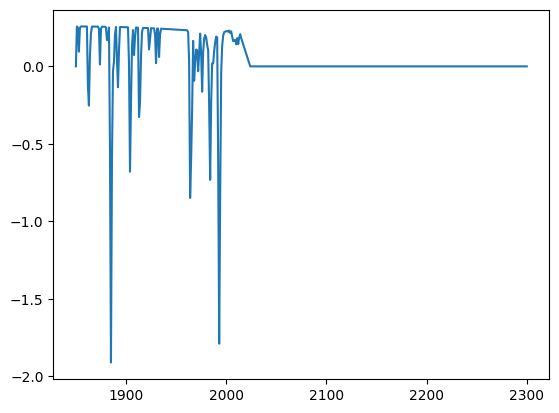

In [22]:
pl.plot(np.arange(1850, 2301), volcanic_1850_2300)

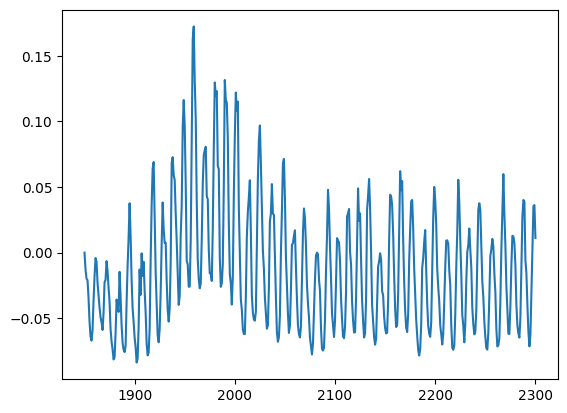

In [23]:
pl.plot(np.arange(1850, 2301), solar_1850_2300)

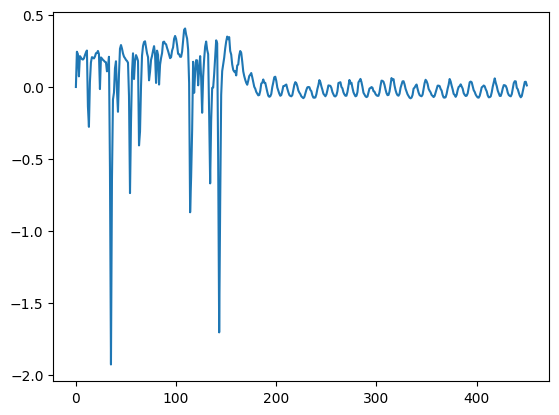

In [24]:
pl.plot(solar_1850_2300 + volcanic_1850_2300)

In [25]:
df_out = pd.DataFrame({
    'solar': solar_1850_2300,
    'volcanic': volcanic_1850_2300
}, index = np.arange(1850, 2301))

In [26]:
df_out.loc[1993]  # time bound, takes the weight of forcing across 1992 year

solar       0.087003
volcanic   -1.790096
Name: 1993, dtype: float64

In [27]:
df_out.to_csv('../data/calibration/natural_forcing.csv')